# List of Keywords we would be interested in (general): 
### (Note that it is impossible to know every subcategory we should expect)
1. Paper
2. Plastic
3. Glass
4. Cardboard
5. Metal
6. Electronic
7. Trash

## Misc....

In [ ]:
import tensorflow as tf
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
batch_size = 16

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.3,
        zoom_range=0.4,
        rotation_range=90,
        horizontal_flip=True,
        #preprocessing_function = preprocess_image
)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)#, preprocessing_function = preprocess_image)

# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        './data/train',  # this is the target directory
       # target_size=(100, 100),  # all images will be resized to 100x100
        batch_size=batch_size,
        class_mode='categorical')  # since we use binary_crossentropy loss, we need categorical labels

# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
        './data/valid',
        #target_size=(100, 100),
        batch_size=batch_size,
        class_mode='categorical')

# this is a similar generator, for validation data
test_generator = test_datagen.flow_from_directory(
        './data/test',
        #target_size=(100, 100),
        batch_size=batch_size, 
        class_mode='categorical')

In [21]:
def padding(image):
    height = image.shape[0]
    width = image.shape[1]

    left_pad, right_pad, top_pad, bottom_pad = 0, 0, 0, 0
    if height > width:
        left_pad = int((height-width) / 2)
        right_pad = height-width-left_pad
    elif width > height:
        top_pad = int((width-height) / 2)
        bottom_pad = width-height-top_pad

    img_square = cv.copyMakeBorder(
        image,
        top_pad,
        bottom_pad,
        left_pad,
        right_pad,
        cv.BORDER_CONSTANT,
        value=(255,255,255)
    )
    return img_square

def toGray(image):
    # toGray converts RGB values to grayscale values by forming a weighted sum of the R, G, and B components:
    # 0.2989 * R + 0.5870 * G + 0.1140 * B 
    # source: https://www.mathworks.com/help/matlab/ref/rgb2gray.html
    image[:,:,0] = 0.2989*image[:,:,0] +  0.5870*image[:,:,1] + 0.1140*image[:,:,2]
    image[:,:,1] = 0.2989*image[:,:,0] +  0.5870*image[:,:,1] + 0.1140*image[:,:,2]
    image[:,:,2] = 0.2989*image[:,:,0] +  0.5870*image[:,:,1] + 0.1140*image[:,:,2]
    return image

def preprocess_image(image):
    #image =toGray(image)
    image = padding(image)
    image_scaled = cv.resize(image, (300, 300))
    #image_scaled = np.true_divide(image_scaled, 255.0)
    #print(image_scaled.shape)
    return image_scaled

In [22]:
file = 'dataset-original/paper/paper297.jpg'
image = cv.imread(file)
height = image.shape[0]
width = image.shape[1]

left_pad, right_pad, top_pad, bottom_pad = 0, 0, 0, 0
if height > width:
    left_pad = int((height-width) / 2)
    right_pad = height-width-left_pad
elif width > height:
    top_pad = int((width-height) / 2)
    bottom_pad = width-height-top_pad

img_square = cv.copyMakeBorder(
    image,
    top_pad,
    bottom_pad,
    left_pad,
    right_pad,
    cv.BORDER_CONSTANT,
    value=(255,255,255)
)
print(img_square.shape[0], img_square.shape[1])
new = padding(image)

4032 4032


In [ ]:
!pip install opencv-python==3.4.2.17 numpy==1.14.5

In [ ]:
import os, sys
import glob
import cv2 as cv
root_dir = "./dataset-original/"
count = 0
total = 2527
for filename in glob.iglob(root_dir + '**/*.jpg', recursive=True):
    count += 1
    print(count,'/',total)
    im = cv.imread(filename)
    pad1 = padding(im)
    new = preprocess_image(im)
    cv.imwrite(filename, new)

In [ ]:
# paths will be train/cardboard, train/glass, etc...
subsets = ['train','valid', 'test']
waste_types = ['cardboard', 'glass', 'metal','paper', 'plastic', 'trash']

## create destination folders for data subset and waste type
for subset in subsets:
    for waste_type in waste_types:
        folder = os.path.join('data',subset,waste_type)
        if not os.path.exists(folder):
            os.makedirs(folder)
            
# if not os.path.exists(os.path.join('data1','test')):
#     os.makedirs(os.path.join('data1','test'))
            
## move files to destination folders for each waste type
for waste_type in waste_types:
    source_folder = os.path.join('dataset-original',waste_type)
    train_ind, valid_ind, test_ind = split_indices(source_folder,1,1)
    try:
        ## move source files to train
        train_names = get_names(waste_type,train_ind)
        train_source_files = [os.path.join(source_folder,name) for name in train_names]
        train_dest = "data/train/"+waste_type
        move_files(train_source_files,train_dest)

        ## move source files to valid
        valid_names = get_names(waste_type,valid_ind)
        valid_source_files = [os.path.join(source_folder,name) for name in valid_names]
        valid_dest = "data/valid/"+waste_type
        move_files(valid_source_files,valid_dest)

        ## move source files to test
        test_names = get_names(waste_type,test_ind)
        test_source_files = [os.path.join(source_folder,name) for name in test_names]
        ## I use data/test here because the images can be mixed up
        test_dest = "data/test/"+waste_type
        move_files(test_source_files,test_dest)
    except:
        print('error')
        pass

## Now let's try to use the trashnet model and only use images with the complete object
#### https://nbviewer.jupyter.org/github/collindching/Waste-Sorter/blob/master/Waste%20sorter.ipynb

# 1. Extract Data from Bucket

In [1]:
!gsutil -q cp -r gs://original-data-amli/dataset-original .

In [2]:
!gsutil -q cp -r gs://original-data-amli/dataset-resized .

# 2. Imports and Organize images into different folders

In [8]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

%config InlineBackend.figure_format = 'retina'

In [4]:
# Your code goes here
from fastai.vision import *
from fastai.metrics import error_rate
from pathlib import Path
from glob2 import glob
from sklearn.metrics import confusion_matrix

import cv2 as cv
import pandas as pd
import numpy as np
import os
import zipfile as zf
import shutil
import re
import seaborn as sns
#Use attached zip file (splits data into train, validation, and testing)

In [9]:
os.listdir(os.path.join(os.getcwd(),"dataset-resized"))


['paper', 'cardboard', 'metal', 'trash', '.DS_Store', 'plastic', 'glass']

In [11]:
## helper functions ##
import random
import shutil
## splits indices for a folder into train, validation, and test indices with random sampling
    ## input: folder path
    ## output: train, valid, and test indices    
def split_indices(folder,seed1,seed2):    
    n = len(os.listdir(folder))
    full_set = list(range(1,n+1))

    ## train indices
    random.seed(seed1)
    train = random.sample(list(range(1,n+1)),int(.5*n))

    ## temp
    remain = list(set(full_set)-set(train))

    ## separate remaining into validation and test
    random.seed(seed2)
    valid = random.sample(remain,int(.5*len(remain)))
    test = list(set(remain)-set(valid))
    
    return(train,valid,test)

## gets file names for a particular type of trash, given indices
    ## input: waste category and indices
    ## output: file names 
def get_names(waste_type,indices):
    file_names = [waste_type+str(i)+".jpg" for i in indices]
    return(file_names)    

## moves group of source files to another folder
    ## input: list of source files and destination folder
    ## no output
def move_files(source_files,destination_folder):
    for file in source_files:
        shutil.move(file,destination_folder)

In [23]:
## paths will be train/cardboard, train/glass, etc...
subsets = ['train','valid', 'test']
waste_types = ['cardboard','glass','metal','paper','plastic','trash']

## create destination folders for data subset and waste type
for subset in subsets:
    for waste_type in waste_types:
        folder = os.path.join('data',subset,waste_type)
        if not os.path.exists(folder):
            os.makedirs(folder)
            
## move files to destination folders for each waste type
for waste_type in waste_types:
    source_folder = os.path.join('dataset-resized',waste_type)
    train_ind, valid_ind, test_ind = split_indices(source_folder,1,1)
    
    ## move source files to train
    train_names = get_names(waste_type,train_ind)
    train_source_files = [os.path.join(source_folder,name) for name in train_names]
    train_dest = "data/train/"+waste_type
    move_files(train_source_files,train_dest)
    
    ## move source files to valid
    valid_names = get_names(waste_type,valid_ind)
    valid_source_files = [os.path.join(source_folder,name) for name in valid_names]
    valid_dest = "data/valid/"+waste_type
    move_files(valid_source_files,valid_dest)
    
    ## move source files to test
    test_names = get_names(waste_type,test_ind)
    test_source_files = [os.path.join(source_folder,name) for name in test_names]
    test_dest = "data/test/"+waste_type
    ## I use data/test here because the images can be mixed up
    move_files(test_source_files,test_dest)

In [13]:
## get a path to the folder with images
path = Path(os.getcwd())/"data"
path


PosixPath('/home/jupyter/data')

In [14]:
tfms = get_transforms(do_flip=True,flip_vert=True)
data = ImageDataBunch.from_folder(path,test="test",ds_tfms=tfms,bs=16)

In [15]:
data

ImageDataBunch;

Train: LabelList (1262 items)
x: ImageList
Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512)
y: CategoryList
paper,paper,paper,paper,paper
Path: /home/jupyter/data;

Valid: LabelList (630 items)
x: ImageList
Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512)
y: CategoryList
paper,paper,paper,paper,paper
Path: /home/jupyter/data;

Test: LabelList (635 items)
x: ImageList
Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512)
y: EmptyLabelList
,,,,
Path: /home/jupyter/data

In [16]:
print(data.classes)

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


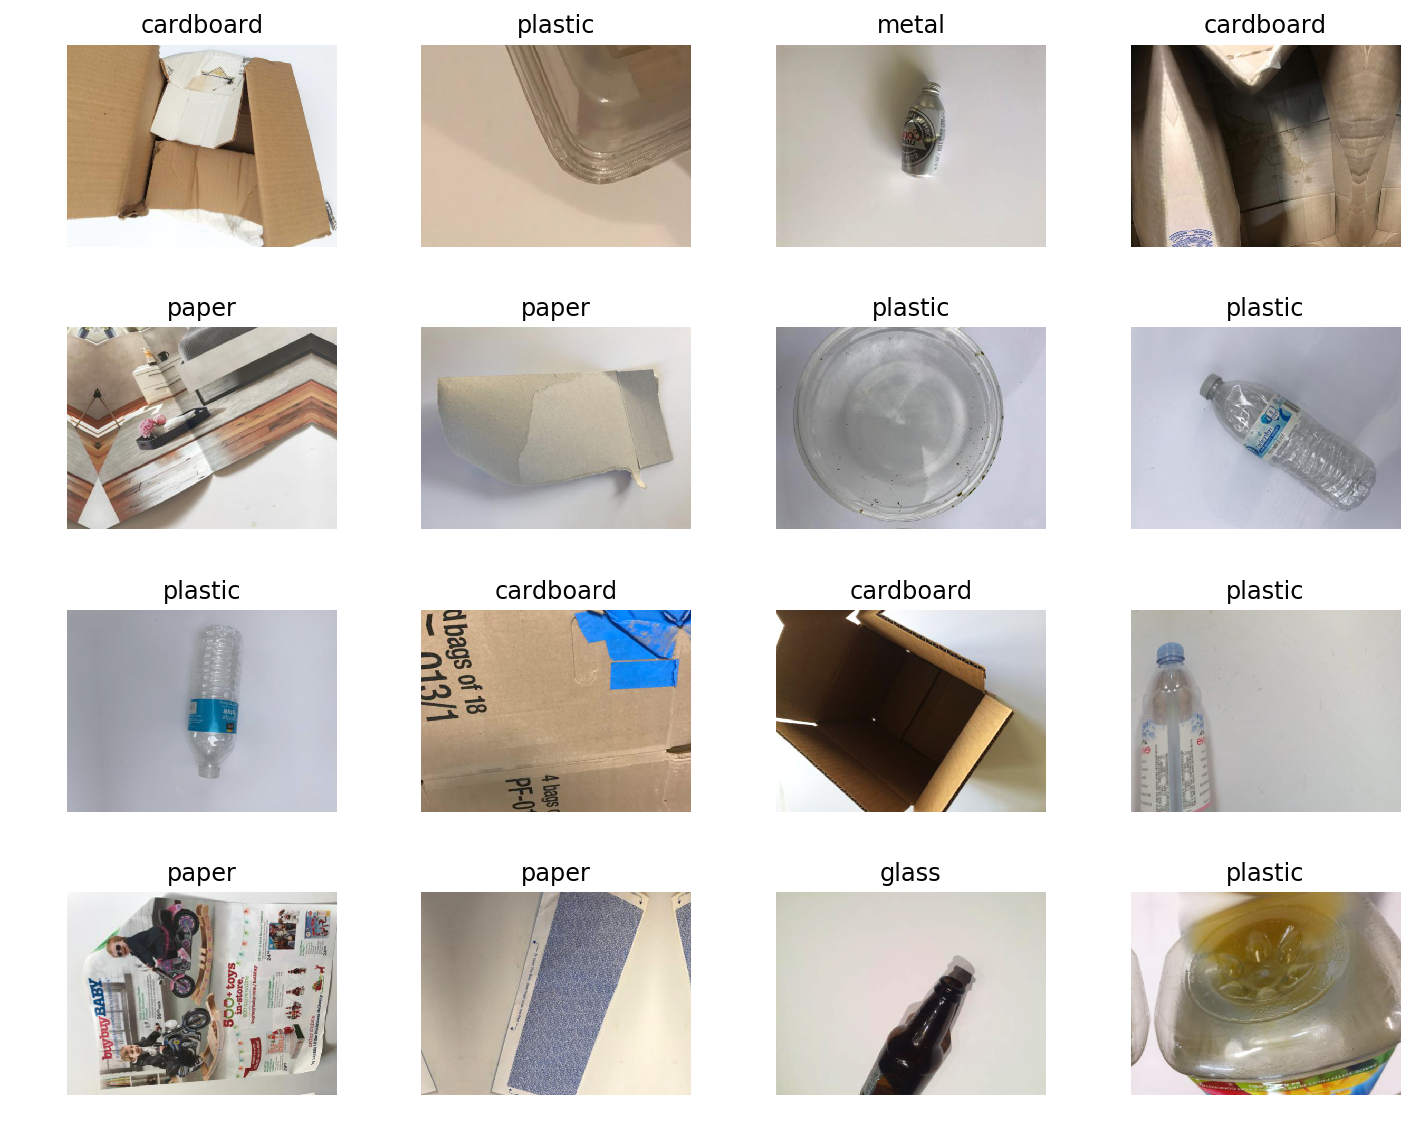

In [17]:
data.show_batch(rows=4,figsize=(10,8))

# 3. Model Training

In [18]:
learn = create_cnn(data,models.resnet34,metrics=error_rate)

/opt/anaconda3/lib/python3.7/site-packages/fastai/vision/learner.py:106: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")
Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /home/jupyter/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:00<00:00, 125431560.54it/s]


In [19]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

## 3.1 Find the ideal learning rate

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


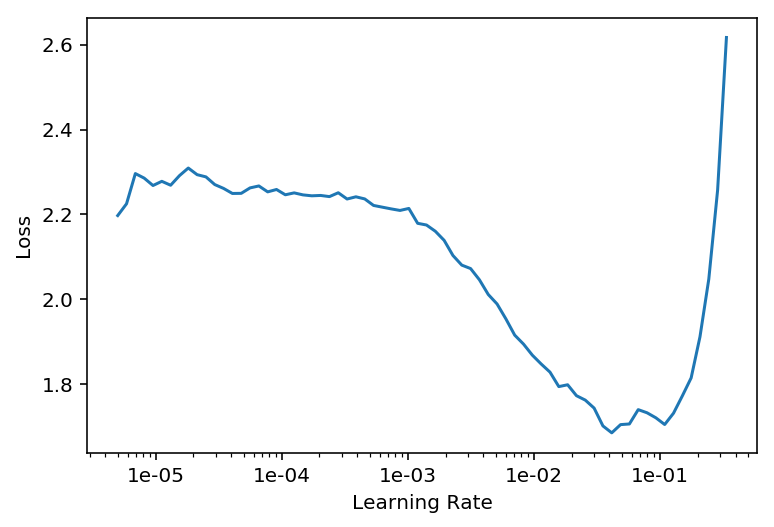

In [20]:
learn.lr_find(start_lr=1e-6,end_lr=1e1)
learn.recorder.plot()

## 3.2 Training

In [25]:
learn.fit_one_cycle(20,max_lr=5.13e-03)


epoch,train_loss,valid_loss,error_rate,time
0,1.426067,0.777700,0.269841,00:41
1,0.939879,0.518018,0.173016,00:39
2,0.701438,0.549425,0.171429,00:40
3,0.616237,0.536437,0.150794,00:39
4,0.686224,0.677549,0.234921,00:39
5,0.604163,0.702425,0.231746,00:39
6,0.591221,0.430599,0.149206,00:40
7,0.551996,0.430610,0.161905,00:40
8,0.507139,0.413124,0.130159,00:40
9,0.499853,0.429095,0.158730,00:40


## 3.3 VIsualizing most incorrect images¶

In [26]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()

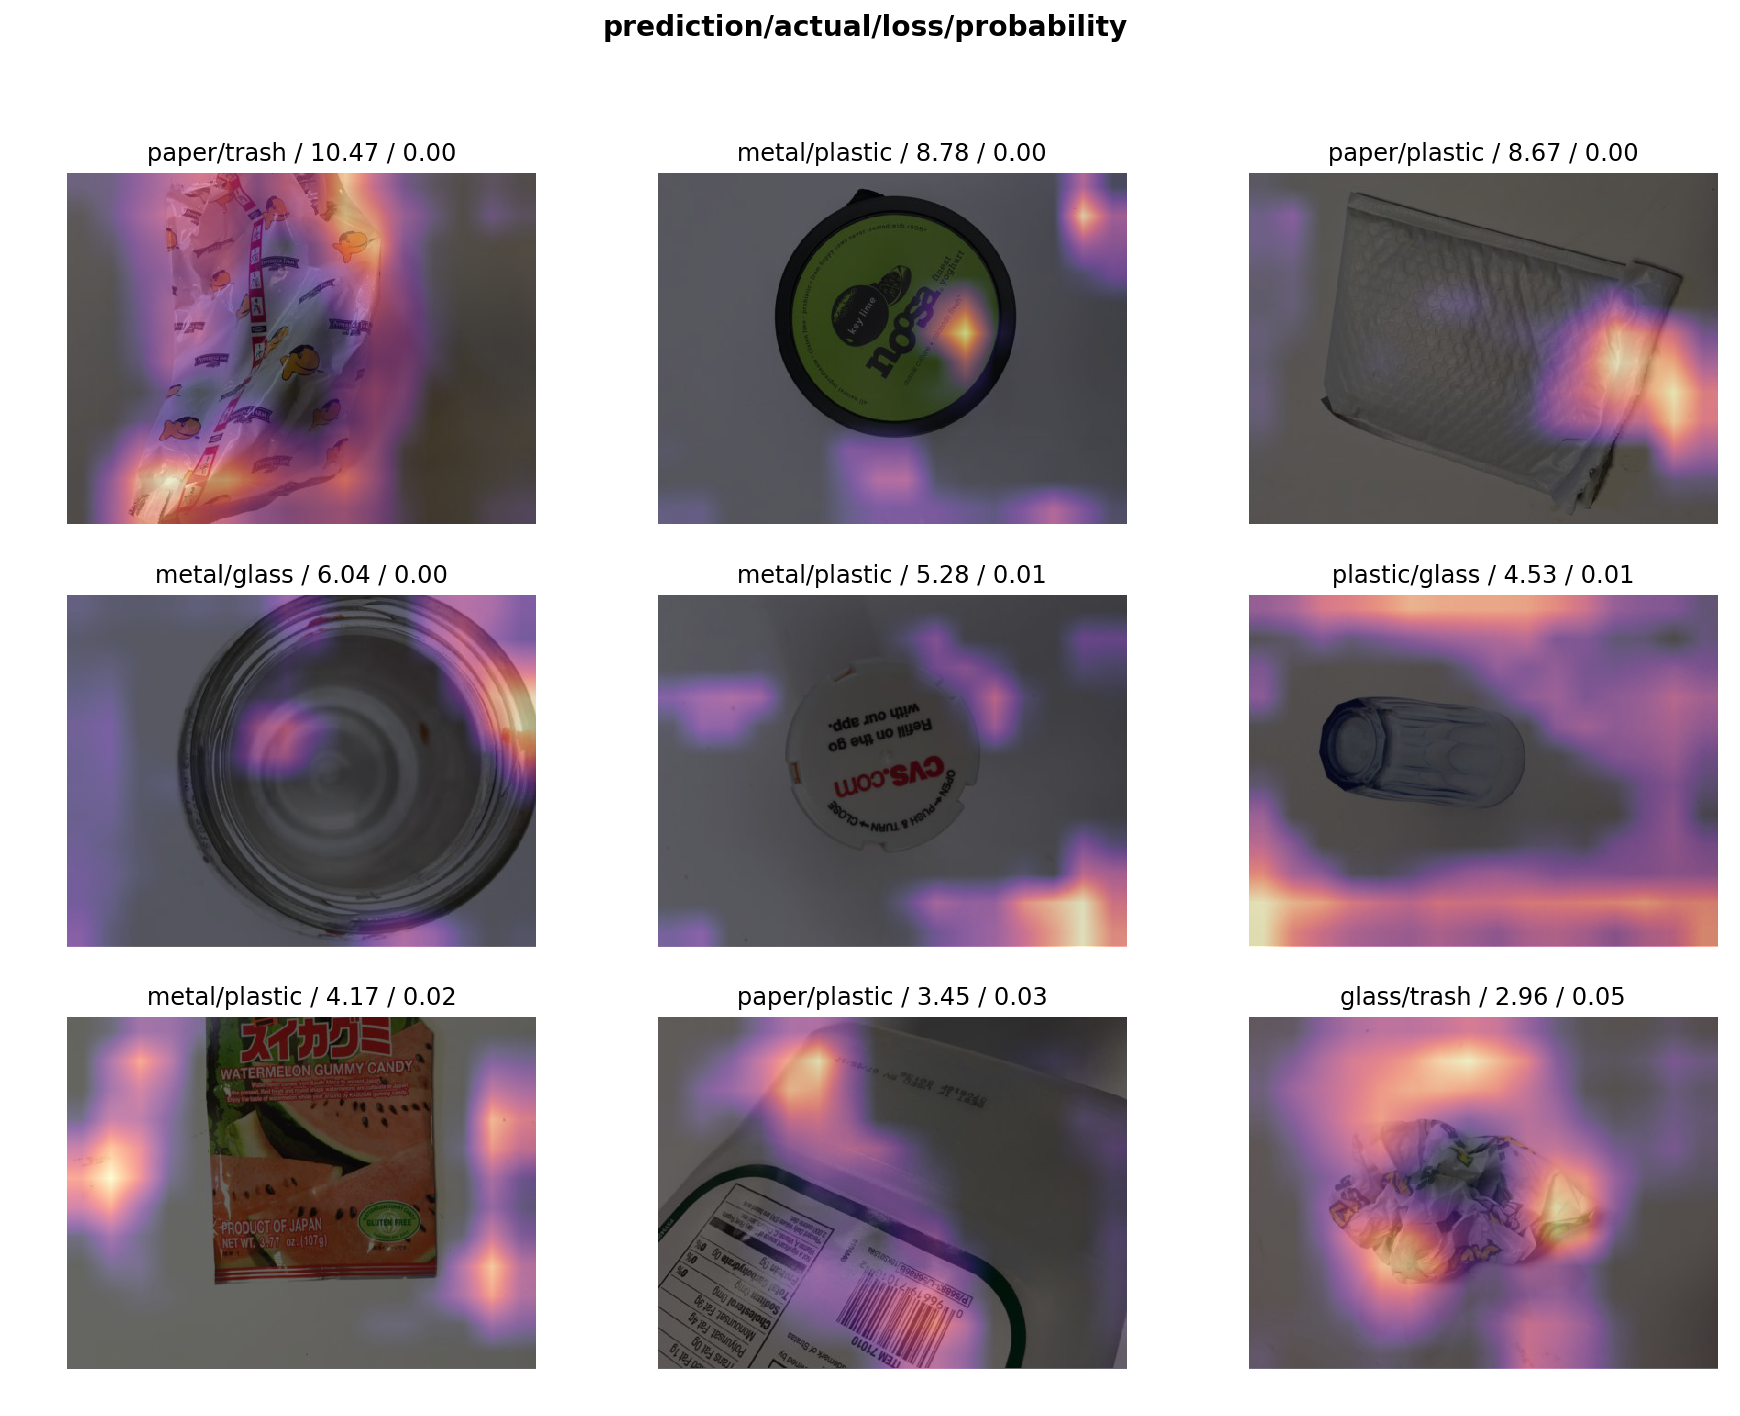

In [27]:
interp.plot_top_losses(9, figsize=(15,11))

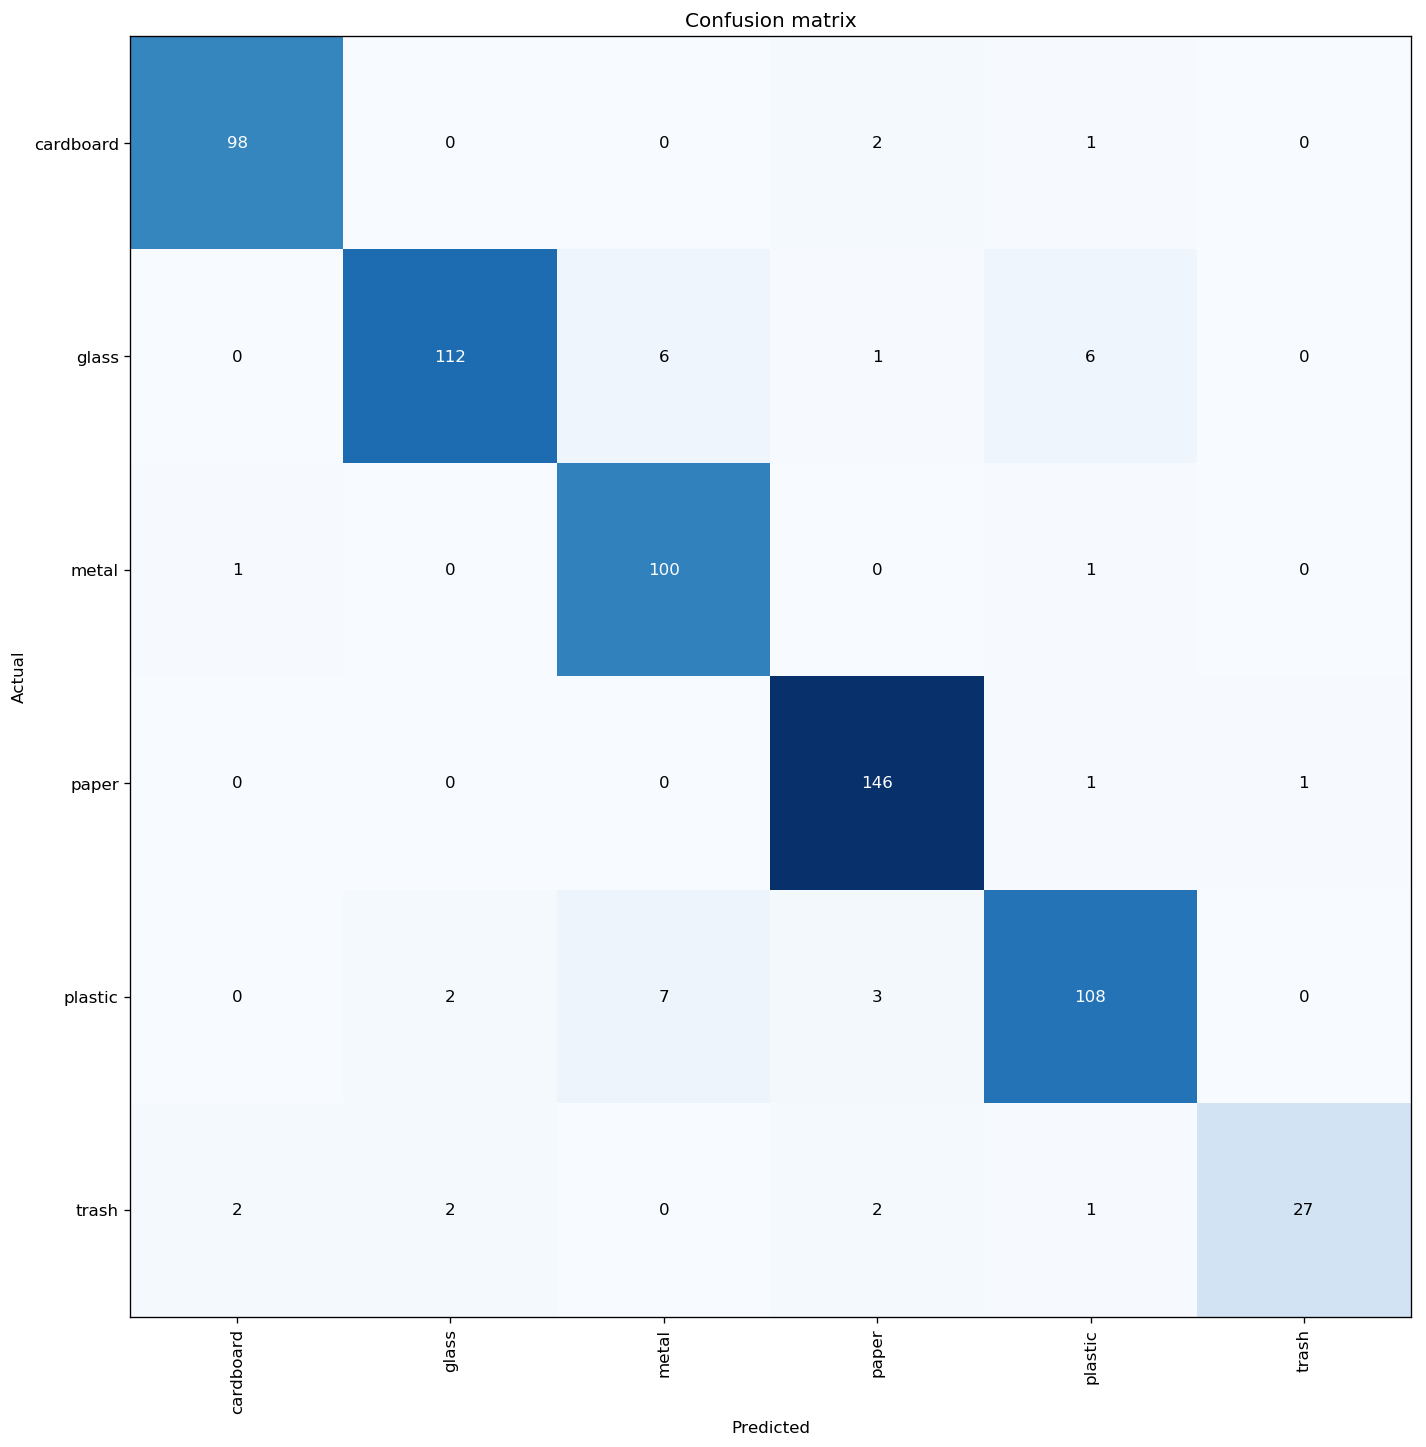

_cl_int_plot_top_losses [source] [test] _cl_int_plot_top_losses ( k , largest = True , figsize = (12, 12) , heatmap : bool = None , heatmap_thresh : int = 16 , return_fig : bool = None ) → Optional [ Figure ] 
 
 × No tests found for _cl_int_plot_top_losses . To contribute a test please refer to this guide and this discussion . Show images in top_losses along with their prediction, actual, loss, and probability of actual class. 
 Show in docs

In [28]:
doc(interp.plot_top_losses)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [29]:
interp.most_confused(min_val=2)

[('plastic', 'metal', 7),
 ('glass', 'metal', 6),
 ('glass', 'plastic', 6),
 ('plastic', 'paper', 3),
 ('cardboard', 'paper', 2),
 ('plastic', 'glass', 2),
 ('trash', 'cardboard', 2),
 ('trash', 'glass', 2),
 ('trash', 'paper', 2)]

## 3.4 Make new predictions on test data

In [30]:
preds = learn.get_preds(ds_type=DatasetType.Test)

In [31]:
print(preds[0].shape)
preds[0]

torch.Size([635, 6])


tensor([[1.0662e-02, 1.5883e-04, 1.6673e-06, 9.8886e-01, 3.4939e-06, 3.1545e-04],
        [3.2887e-04, 2.4308e-05, 2.6627e-05, 9.9944e-01, 1.5503e-04, 2.7820e-05],
        [7.1500e-06, 1.2187e-05, 7.8170e-06, 9.9996e-01, 3.9706e-06, 4.0778e-06],
        ...,
        [5.1613e-05, 9.9896e-01, 4.8752e-06, 7.1307e-05, 9.0489e-04, 8.1522e-06],
        [5.7688e-03, 4.5084e-01, 3.3166e-01, 7.8014e-03, 1.9742e-01, 6.5134e-03],
        [2.2239e-05, 9.9974e-01, 2.3135e-04, 1.2945e-07, 5.7767e-06, 6.1080e-08]])

In [32]:
data.classes

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

In [33]:
## saves the index (0 to 5) of most likely (max) predicted class for each image
max_idxs = np.asarray(np.argmax(preds[0],axis=1))

In [34]:
yhat = []
for max_idx in max_idxs:
    yhat.append(data.classes[max_idx])

In [35]:
yhat[:5]

['paper', 'paper', 'paper', 'paper', 'paper']

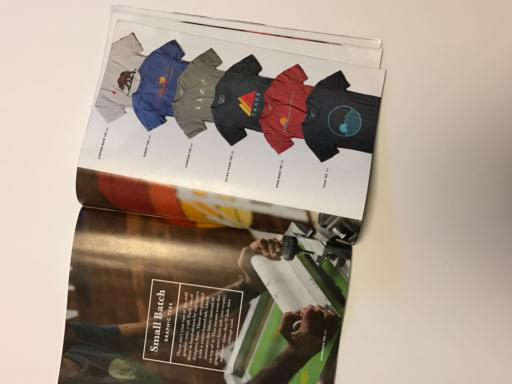

In [36]:
learn.data.test_ds[0][0]

In [37]:
y = []

## convert POSIX paths to string first
for label_path in data.test_ds.items:
    y.append(str(label_path))
    
## then extract waste type from file path
pattern = re.compile("([a-z]+)[0-9]+")
for i in range(len(y)):
    y[i] = pattern.search(y[i]).group(1)

In [38]:
## predicted values
print(yhat[0:5])
## actual values
print(y[0:5])

['paper', 'paper', 'paper', 'paper', 'paper']
['paper', 'paper', 'paper', 'paper', 'paper']


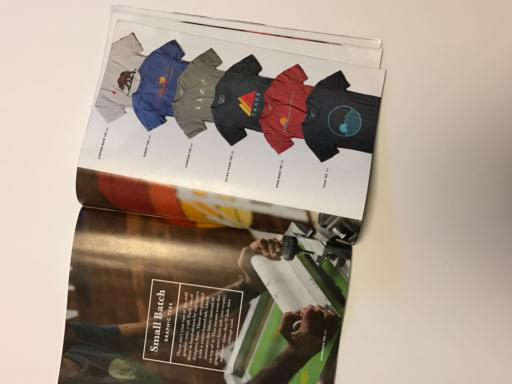

In [39]:
learn.data.test_ds[0][0]

In [40]:
cm = confusion_matrix(y,yhat)
print(cm)

[[ 97   0   2   2   0   0]
 [  0 111   9   1   5   0]
 [  1   4  94   2   2   0]
 [  1   0   0 146   0   2]
 [  0   3   0   1 114   3]
 [  1   1   0   6   3  24]]


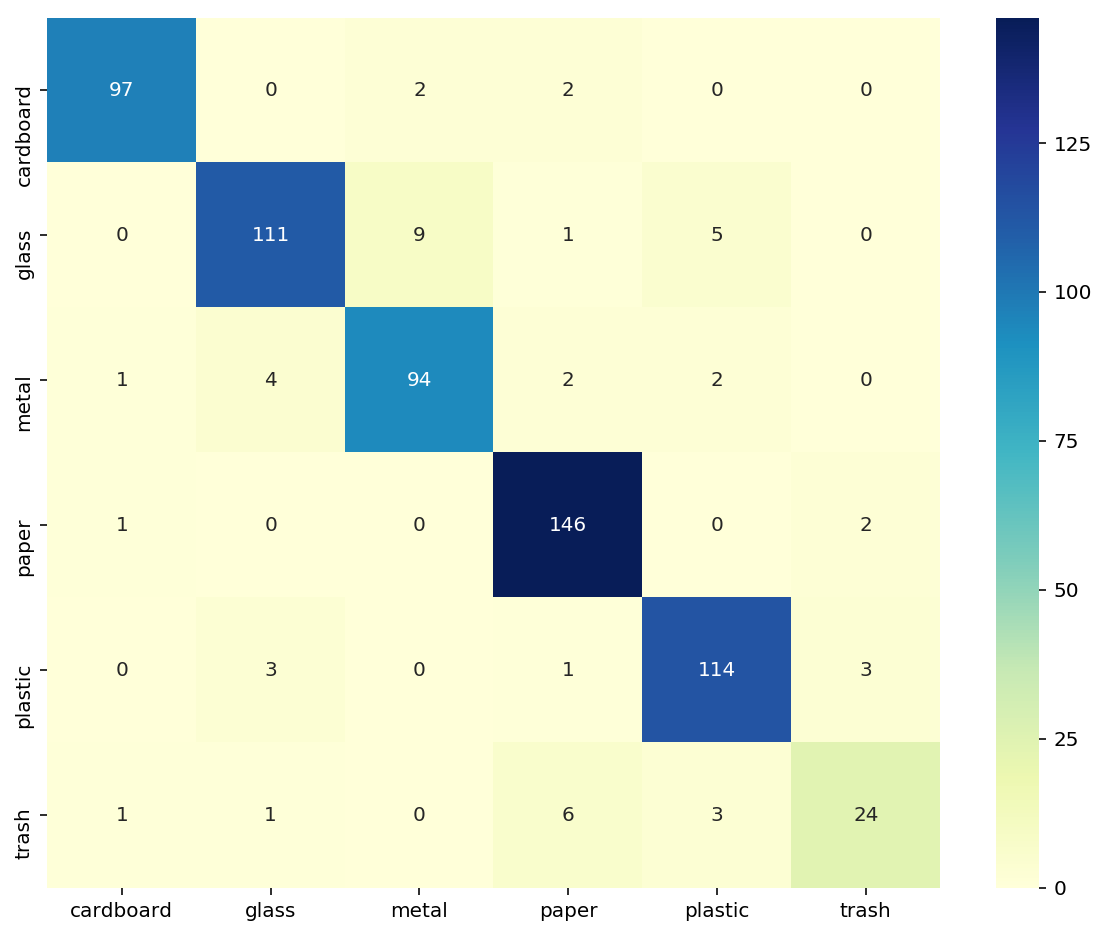

In [41]:
df_cm = pd.DataFrame(cm,waste_types,waste_types)

plt.figure(figsize=(10,8))
sns.heatmap(df_cm,annot=True,fmt="d",cmap="YlGnBu")

In [42]:
correct = 0

for r in range(len(cm)):
    for c in range(len(cm)):
        if (r==c):
            correct += cm[r,c]

In [43]:
accuracy = correct/sum(sum(cm))
accuracy

0.9228346456692913

In [44]:
# ## delete everything when you're done to save space
# shutil.rmtree("data")
# shutil.rmtree('dataset-resized')